In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
w_wine = pd.read_csv('datasets/winequality-white.csv', sep = ';')
r_wine = pd.read_csv('datasets/winequality-red.csv', sep = ';')

In [3]:
x = r_wine.iloc[:, 0:-1]
y = r_wine.iloc[:, -1]

In [4]:
from sklearn.model_selection import train_test_split
y = pd.get_dummies(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=111)
x_train = np.array(x_train)
x_test = np.array(x_test)

In [5]:
n_classes = y.shape[1]

In [6]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 3. Implementação da RNA

## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [7]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics

pd.set_option("display.max_columns", None)

2022-11-20 16:35:04.714901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 16:35:05.117085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 16:35:05.117130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 16:35:05.194615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 16:35:06.295537: W tensorflow/stream_executor/platform/de

In [8]:
score_acc = make_scorer(accuracy_score)

In [9]:
def optmize_cnn(dropout_rate, normalization, neurons,optimizer,
                learning_rate, layers1, layers2, neurons1, neurons2, dropout):


    classificador = Sequential()

    classificador.add(Dense(units = neurons, activation='relu', input_dim = 11))
    
    if normalization > 0.5:
        classificador.add(BatchNormalization())

    for i in range(layers1):
        classificador.add(Dense(neurons1, activation='relu'))
        
    if dropout > 0.5:
        classificador.add(Dropout(dropout_rate, seed=123))

    for i in range(layers2):
        classificador.add(Dense(neurons2, activation='relu'))


    classificador.add(Dense(n_classes, activation="softmax"))

    classificador.compile(loss='categorical_crossentropy', 
                    optimizer=optimizer(learning_rate=learning_rate), metrics=['accuracy'])

    return classificador

In [10]:
def evaluate_network(dropout, normalization, learning_rate, neurons,optimizer, epochs, 
                    batch_size, layer1, layer2, neurons1, neurons2, dropout_rate):
    
    neurons = round(neurons)
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    optimizer = round(optimizer)
    epochs = round(epochs)
    batch_size = round(batch_size)
    layer1 = round(layer1)
    layer2 = round(layer2)


    optimizer_array = [Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl, SGD]
    optimizer_val = optimizer_array[optimizer]

    model = optmize_cnn(dropout_rate, normalization, neurons,optimizer_val,
                learning_rate, layer1, layer2, neurons1, neurons2, dropout)

    
    # Train on the bootstrap sample
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=50)

    nn = KerasClassifier(model=model, epochs=epochs, batch_size=batch_size, verbose=0)

    score = cross_val_score(nn, x_train, y_train, scoring=score_acc, cv=5, fit_params={'callbacks':[es]}).mean()
    
    return score

In [11]:
pbounds = {'dropout': (0.0, 0.3),
            'normalization':(0, 1),
            'learning_rate': (0.0, 0.1),
            'neurons': (4, 64),
            'optimizer': (0, 7),
            'epochs' : (50, 300),
            'batch_size': (10, 150),
            'layer1': (1,3),
            'layer2': (1,3),
            'neurons1': (4, 64),
            'neurons2': (4, 64),
            'dropout_rate': (0,0.3)
            }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

In [12]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=25, n_iter=20,)

|   iter    |  target   | batch_... |  dropout  | dropou... |  epochs   |  layer1   |  layer2   | learni... |  neurons  | neurons1  | neurons2  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


2022-11-20 16:35:07.627588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-20 16:35:07.627896: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 16:35:07.627929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gbriel-pc): /proc/driver/nvidia/version does not exist
2022-11-20 16:35:07.629368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///tmp/tmpjdsj5f9z/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2an0az0j/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5sf1pgg2/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpeee1bbgn/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpik_51c7e/assets
| 1         | 0.5354    | 68.38     | 0.2161    | 3.431e-05 | 125.6     | 1.294     | 1.185     | 0.01863   | 24.73     | 27.81     | 36.33     | 0.4192    | 4.797     |
INFO:tensorflow:Assets written to: ram:///tmp/tmpnb3a0fga/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpm3ugv2mh/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpu0ocm4pg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp8obzx3hw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpezdzdbsh/assets
| 2         | 0.5755    | 38.62     | 0.2634    | 0.008216  | 217.6     | 1.835     | 2.117     | 0.01404   | 15.89     | 52.04     | 62.1      | 0.3134    | 4.846     |
INFO:tenso

In [13]:
params_nn_ = optimizer.max['params']
learning_rate = params_nn_['learning_rate']
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = [Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl, Adam]
params_nn_['optimizer'] = optimizerL[round(params_nn_['optimizer'])]
params_nn_['layer1'] = round(params_nn_['layer1'])
params_nn_['layer2'] = round(params_nn_['layer2'])
params_nn_['neurons1'] = round(params_nn_['neurons1'])
params_nn_['neurons2'] = round(params_nn_['neurons2'])
params_nn_

{'batch_size': 65,
 'dropout': 0.1457972001290729,
 'dropout_rate': 0.18129314487599196,
 'epochs': 187,
 'layer1': 3,
 'layer2': 3,
 'learning_rate': 0.03948756129235549,
 'neurons': 62,
 'neurons1': 14,
 'neurons2': 12,
 'normalization': 0.13507915804673132,
 'optimizer': keras.optimizers.optimizer_v2.adagrad.Adagrad}

In [14]:
model = optmize_cnn(params_nn_['dropout_rate'], params_nn_['normalization'], params_nn_['neurons'],params_nn_['optimizer'],
                    params_nn_['learning_rate'], params_nn_['layer1'], params_nn_['layer2'], params_nn_['neurons1'],
                    params_nn_['neurons2'], params_nn_['dropout'])


nn = KerasClassifier(model=model, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'], verbose=0)

nn.fit(x_train, y_train, verbose=1)

Epoch 1/187
19/19 [==============================] - 1s 2ms/step - loss: 1.5183 - accuracy: 0.3820
Epoch 2/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1898 - accuracy: 0.4554
Epoch 3/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1844 - accuracy: 0.4354
Epoch 4/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1575 - accuracy: 0.4846
Epoch 5/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1686 - accuracy: 0.4787
Epoch 6/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1517 - accuracy: 0.4829
Epoch 7/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1495 - accuracy: 0.4754
Epoch 8/187
19/19 [==============================] - 0s 2ms/step - loss: 1.1457 - accuracy: 0.4862
Epoch 9/187
19/19 [==============================] - 0s 1ms/step - loss: 1.1476 - accuracy: 0.4979
Epoch 10/187
19/19 [==============================] - 0s 1ms/step - loss: 1.1487 - accuracy: 0.4812
Epoch 11/

KerasClassifier(
	model=<keras.engine.sequential.Sequential object at 0x7f24542d1480>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=65
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=187
	class_weight=None
)

In [15]:
nn.score(x_test, y_test)

0.5775

In [17]:
y

,3,4,5,6,7,8
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
1594,0,0,1,0,0,0
1595,0,0,0,1,0,0
1596,0,0,0,1,0,0
1597,0,0,1,0,0,0


In [18]:
y_pred = nn.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = [3,4,5,6,7,8]


In [19]:
y_test = y_test.idxmax(axis=1)
y_pred = y_pred.idxmax(axis=1)

In [20]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[  0,   0,   2,   1,   0,   0],
       [  0,   0,   9,   1,   0,   0],
       [  0,   0, 121,  44,   1,   0],
       [  0,   0,  55,  97,  10,   0],
       [  0,   0,   1,  40,  13,   0],
       [  0,   0,   0,   3,   2,   0]])

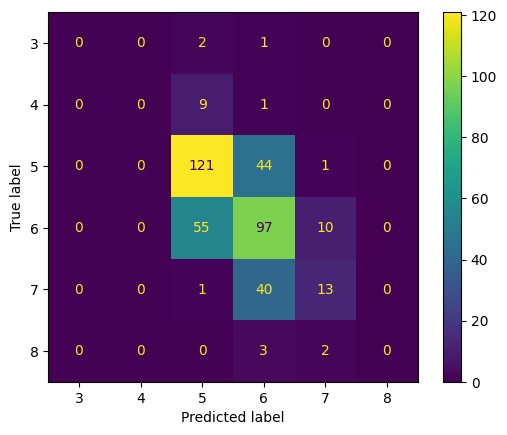

In [21]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8])
cm_display.plot()

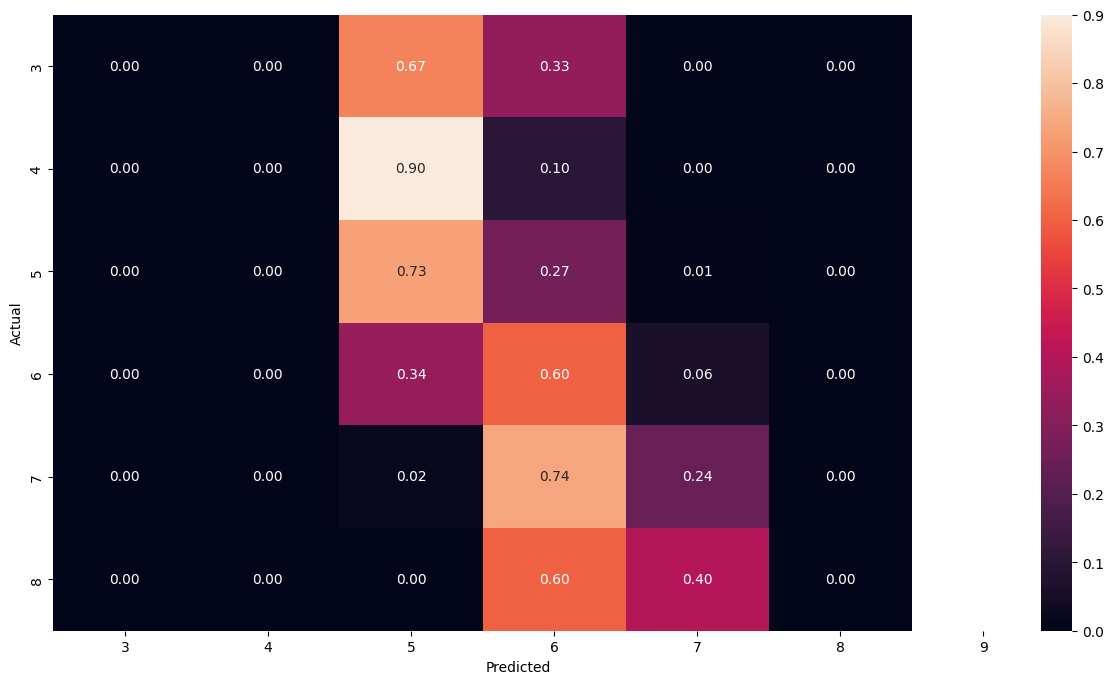

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)